<a href="https://colab.research.google.com/github/AndiAsyraf03/Assigment_4/blob/main/Revisi1TubesNLP_0102522032.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Dampak Standardisasi Model Emosi dan Kualitas Dataset terhadap Generalisasi Sistem Deteksi Emosi Multi-label Berbahasa Indonesia**

#**1. Persiapan Lingkungan dan Dataset**

###**1.1 Instalasi dan Impor Dependensi**

In [1]:
# Instalasi library yang dibutuhkan
!pip install -U transformers datasets sentencepiece Sastrawi nltk gensim bpemb scikit-learn textstat

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Download NLTK resource untuk tokenisasi
import nltk
nltk.download('all')

# Impor dependensi utama
import pandas as pd
import numpy as np
import torch
import re
import string
import random
import nltk
import math
import matplotlib.pyplot as plt
import seaborn as sns
import textstat
import tensorflow as tf
import os, requests
import gensim.downloader as api


# NLP: Preprocessing dan embeddings
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from gensim.models import KeyedVectors
from bpemb import BPEmb
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import KeyedVectors
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader

# Transformers dan model
from transformers import (AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments, BertTokenizer, BertModel)
from transformers.training_args import IntervalStrategy
from transformers import pipeline


# Sklearn: evaluasi & baseline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

In [4]:
from transformers import BertModel, BertConfig, BertTokenizer, BertPreTrainedModel
from transformers import BertForSequenceClassification
from torch import nn

###**1.2 Akses dan Konsolidasi Dataset**

In [5]:
df_path_anotasi= '/content/drive/MyDrive/Data_NLP/df_anotasi.parquet'

df_anotasi = pd.read_parquet(df_path_anotasi)

# Dataset SemEval
dev_path = "/content/drive/MyDrive/Data_NLP/dev-00000-of-00001.parquet"
test_path = "/content/drive/MyDrive/Data_NLP/test-00000-of-00001.parquet"

df_dev = pd.read_parquet(dev_path)
df_test = pd.read_parquet(test_path)

df_semeval = pd.concat([df_dev, df_test], ignore_index=True)
df_semeval = df_semeval.drop('id', axis=1)

df = pd.concat([df_anotasi, df_semeval], ignore_index=True)

#menghapus baris jika kolom emotion null / []
df = df[df['emotions'].notna() & (df['emotions'].apply(lambda x: len(x) > 0))]

###**1.3 Pra-pemrosesan Data**

# **SEL INI JANGAN DI RUN**

In [6]:
# Buat stemmer dan stopword list Bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words("indonesian"))

# Fungsi normalisasi dan pembersihan teks
def clean_text(text):
    text = text.lower()                             # lowercase
    text = re.sub(r"http\\S+", "", text)            # hapus URL
    text = re.sub(r'[^a-z0-9\s]', '', text)         # hapus karakter non-alphanumeric
    text = re.sub(r"\\s+", " ", text).strip()       # hapus spasi ganda
    return text

# (clean → tokenize → stopword → stem)
def preprocess_text(text, apply_stopword=True, apply_stemming=False):
    text = clean_text(text)
    tokens = word_tokenize(text)

    if apply_stopword:
        tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

    if apply_stemming:
        tokens = [stemmer.stem(word) for word in tokens]

    return " ".join(tokens)

# Terapkan ke kolom 'text'
df['text_clean'] = df['text'].apply(lambda x: preprocess_text(x, apply_stopword=True, apply_stemming=True))

In [10]:
df.to_parquet('df_Stemming.parquet', index=False)

In [32]:
df

,text,joy,surprise,anger,disgust,fear,sadness,emotions,text_clean,ari,cli,word_count,ttr,herdan,entropy,noun,verb,adj,other_pos,word_quality
0,"Apapun yang Anda putuskan untuk dilakukan, pas...",1,0,0,0,0,0,[joy],apa putus pasti bahagia,4.120000,5.800000,4,1.000000,1.000000,2.000000,4,0,0,0,low
1,"bingung banget si, kaget..tapi mari kita hadap...",1,1,0,0,0,0,"[joy, surprise]",bingung banget si kagettapi mari hadap percaya...,9.475000,13.140000,10,1.000000,1.000000,3.321928,10,0,0,0,medium
2,"Ya Allah Bioskop TransTv ""Misteri di rusun 313...",0,0,0,0,1,0,[fear],ya allah bioskop transtv misteri rusun 313 bik...,8.062000,11.400000,10,1.000000,1.000000,3.321928,9,0,0,1,medium
3,gak ada gunanya hidup,0,0,0,0,0,1,[sadness],gak guna hidup,-1.090000,-2.466667,3,1.000000,1.000000,1.584963,3,0,0,0,low
4,aku tidak berakhir dengan pria populer itu seb...,0,0,0,0,0,1,[sadness],pria populer asa milik tolak putus cinta pikir,5.531250,8.775000,8,1.000000,1.000000,3.000000,6,1,1,0,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476,jelas bandingke 😅 karena banyak yg lebih darim...,0,0,1,1,0,0,"[anger, disgust]",bandingke yg dari dengar maaf udah ngak lihat ...,5.907273,8.400000,11,1.000000,1.000000,3.459432,8,1,1,1,medium
3477,bisa ditambahkan subtitle bhs indo atau bhs in...,0,0,0,0,0,1,[sadness],subtitle bhs indo bhs ing biar biar paham alur...,4.294000,6.760000,10,0.800000,0.903090,2.921928,8,1,1,0,medium
3478,engkaulah takdirku versi 3pemuda berbahaya :),1,0,0,0,0,0,[joy],engkau takdir versi 3pemuda bahaya,9.330000,13.080000,5,1.000000,1.000000,2.321928,4,0,0,1,low
3480,saya komen positif aja (+) takut ada ipo sama ...,0,0,1,0,1,0,"[anger, fear]",komen positif aja takut ipo sensor kpi,3.601429,6.485714,7,1.000000,1.000000,2.807355,5,1,1,0,low


#**2. Analisis Kualitas Dataset dan Manipulasi**

###**2.1 Perhitungan dan Manipulasi Metrik Kualitas Dataset**

In [12]:
# Metrik keterbacaan
df['ari'] = df['text_clean'].apply(textstat.automated_readability_index)
df['cli'] = df['text_clean'].apply(textstat.coleman_liau_index)
df['word_count'] = df['text_clean'].apply(lambda x: len(x.split()))

In [13]:
def ttr(text):
    tokens = text.split()
    return len(set(tokens)) / len(tokens) if tokens else 0

def herdan_c(text):
    tokens = text.split()
    return math.log(len(set(tokens))) / math.log(len(tokens)) if len(tokens) > 1 else 0

def entropy(text):
    tokens = text.split()
    total = len(tokens)
    freqs = Counter(tokens)
    return -sum((c/total) * math.log2(c/total) for c in freqs.values()) if total else 0

# Metrik struktur
df['ttr'] = df['text_clean'].apply(ttr)
df['herdan'] = df['text_clean'].apply(herdan_c)
df['entropy'] = df['text_clean'].apply(entropy)

In [14]:
# Representativitas
def gini_index(labels):
    flat = [l for sub in labels for l in sub]
    total = len(flat)
    if total == 0: return 0
    p = [c/total for c in Counter(flat).values()]
    return 1 - sum(i**2 for i in p)

def simpson_index(labels):
    flat = [l for sub in labels for l in sub]
    total = len(flat)
    if total == 0: return 0
    p = [c/total for c in Counter(flat).values()]
    return 1 - sum(i**2 for i in p)

In [15]:
def pos_counts(text):
    tags = pos_tag(word_tokenize(text), tagset='universal')
    counts = Counter(tag for _, tag in tags)
    return {
        'NOUN': counts.get('NOUN', 0),
        'VERB': counts.get('VERB', 0),
        'ADJ': counts.get('ADJ', 0),
        'OTHER': sum(counts.get(tag, 0) for tag in ['ADV','ADP','CONJ','DET','NUM','PRON','PRT','X','.'])
    }

# Metrik POS
pos = df['text_clean'].apply(pos_counts)
df['noun'] = pos.apply(lambda x: x['NOUN'])
df['verb'] = pos.apply(lambda x: x['VERB'])
df['adj'] = pos.apply(lambda x: x['ADJ'])
df['other_pos'] = pos.apply(lambda x: x['OTHER'])

In [16]:
# Gini & Simpson di level dataset
gini = gini_index(df['emotions'])
simpson = simpson_index(df['emotions'])
print(f"Gini Index (Dataset): {gini:.4f}")
print(f"Simpson's Diversity Index: {simpson:.4f}")

Gini Index (Dataset): 0.8012
Simpson's Diversity Index: 0.8012


In [17]:
# Kategori kualitas berdasarkan quantile
q1, q2 = df['word_count'].quantile([0.33, 0.66])
df['word_quality'] = df['word_count'].apply(
    lambda x: 'low' if x <= q1 else 'high' if x > q2 else 'medium'
)

# Ringkasan
print("Distribusi Word Count:")
print(df['word_quality'].value_counts())

Distribusi Word Count:
word_quality
low       1302
high      1158
medium     957
Name: count, dtype: int64


#**3. Pengembangan dan Pelatihan Model**

###**3.1 BiLSTM**

###**3.1.1 Word Embeddings**

In [18]:
embedding_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz"
embedding_path = "cc.id.300.vec.gz"

# Unduh jika belum ada
if not os.path.exists(embedding_path):
    with open(embedding_path, "wb") as f:
        f.write(requests.get(embedding_url).content)

In [19]:
# Load dari file .vec.gz
word_vectors = KeyedVectors.load_word2vec_format(embedding_path, binary=False)

In [20]:
# Tokenisasi teks
texts = df['text_clean'].tolist()
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Buat word index dan vocab size
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # +1 for padding token

# Embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

missing_words = 0
for word, i in word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
        missing_words += 1

print(f"Vocab size: {vocab_size}")
print(f"Jumlah kata yang tidak ditemukan di FastText: {missing_words}")

Vocab size: 11005
Jumlah kata yang tidak ditemukan di FastText: 2571


In [21]:
# Konversi teks ke urutan integer
sequences = tokenizer.texts_to_sequences(texts)

# Hitung distribusi panjang teks
lengths = [len(seq) for seq in tokenizer.texts_to_sequences(texts)]

# Pakai 95% quantile:
maxlen = int(np.percentile(lengths, 95))
X = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

# Target multi-label dalam format one-hot (misalnya ['joy', 'fear'] → [1,0,1,0,...])
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['emotions'])

print("Shape X:", X.shape)
print("Shape y:", y.shape)

Shape X: (3417, 28)
Shape y: (3417, 6)


###**3.1.2 Arsitektur BiLSTM**

In [22]:
# Jumlah label (6 emosi dasar)
num_labels = y.shape[1]

# Model BiLSTM
model_bilstm = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=False  # Ubah ke True jika ingin fine-tune
    ),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),  # Regularisasi setelah LSTM
    Dense(64, activation='relu'),
    Dropout(0.3),  # Regularisasi tambahan
    Dense(num_labels, activation='sigmoid')  # Multi-label pakai sigmoid
])

model_bilstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,301,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,301,500 (12.59 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,301,500 (12.59 MB)

In [23]:
# Kompilasi model
model_bilstm.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

# EarlyStopping (berhenti jika val_loss stagnan)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Pelatihan
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.2165 - loss: 0.6315 - val_accuracy: 0.3421 - val_loss: 0.5391
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3635 - loss: 0.5398 - val_accuracy: 0.3743 - val_loss: 0.5256
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4174 - loss: 0.5153 - val_accuracy: 0.4240 - val_loss: 0.5167
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5046 - loss: 0.4829 - val_accuracy: 0.4269 - val_loss: 0.4923
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5075 - loss: 0.4568 - val_accuracy: 0.4181 - val_loss: 0.4993
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5295 - loss: 0.4361 - val_accuracy: 0.4444 - val_loss: 0.4973
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5452 - loss: 0.4116 - val_accuracy: 0.4576 - val_loss: 0.5189


In [24]:
# Prediksi dan Evaluasi
y_pred = model_bilstm.predict(X_val)
y_pred_bin = (y_pred > 0.5).astype(int)

# Tampilkan classification report
print(classification_report(y_val, y_pred_bin, target_names=mlb.classes_))

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

       anger       0.78      0.25      0.38       206
     disgust       0.00      0.00      0.00        97
        fear       0.40      0.01      0.03       140
         joy       0.65      0.65      0.65       303
     sadness       0.52      0.28      0.36       238
    surprise       0.00      0.00      0.00        78

   micro avg       0.63      0.30      0.40      1062
   macro avg       0.39      0.20      0.24      1062
weighted avg       0.51      0.30      0.34      1062
 samples avg       0.44      0.34      0.37      1062



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


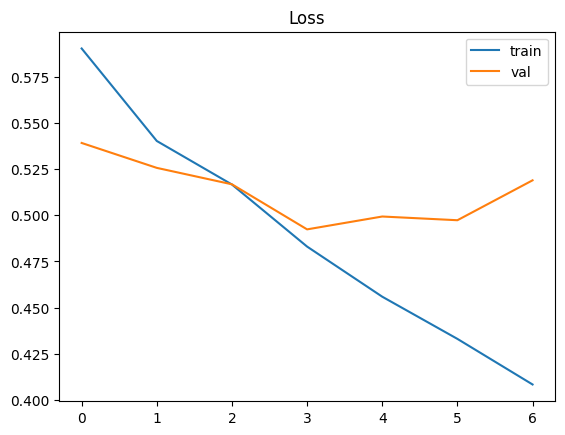

In [25]:
plt.plot(history_bilstm.history['loss'], label='train')
plt.plot(history_bilstm.history['val_loss'], label='val')
plt.legend(); plt.title('Loss')
plt.show()

###**3.2 Transformer**

###**3.2.1 Indo-BERT**

In [26]:
# Load tokenizer IndoBERT
indobert_tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Ambil teks dan label multi-label
texts_indo = df["text"].tolist()
labels_indo = df["emotions"]

# Tokenisasi dengan padding dan truncation
tokenized_indo = indobert_tokenizer(
    texts_indo,
    padding=True,
    truncation=True,
    max_length=128,  # bisa disesuaikan
    return_tensors="pt"
)

# Encode label multi-label ke multi-hot (float tensor)
mlb_indo = MultiLabelBinarizer()
encoded_labels_indo = mlb_indo.fit_transform(labels_indo)
labels_tensor_indo = torch.tensor(encoded_labels_indo).float()

# Split input dan attention mask
input_ids = tokenized_indo['input_ids']
attention_mask = tokenized_indo['attention_mask']
print("Contoh token:", tokenized_indo['input_ids'][0])
print("Contoh label:", labels_tensor_indo[7])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Contoh token: tensor([    2,  2512,    34,   145, 19154,    90,   477, 30468,  4163,   269,
          137,   386,   145, 30459,  4771, 30470,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [27]:
# Custom Dataset class
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Split data
X_train, X_val, mask_train, mask_val, y_train, y_val = train_test_split(
    input_ids, attention_mask, labels_tensor_indo,
    test_size=0.2, random_state=42
)

train_dataset = EmotionDataset(X_train, mask_train, y_train)
val_dataset = EmotionDataset(X_val, mask_val, y_val)

# Load model IndoBERT
indobert_model = AutoModelForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=labels_tensor_indo.shape[1],
    problem_type="multi_label_classification"
)

# Custom Trainer untuk BCEWithLogitsLoss
from torch.nn import BCEWithLogitsLoss
from transformers import Trainer

class MultiLabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # Tambahkan **kwargs
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results-indobert",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    eval_strategy=IntervalStrategy.EPOCH,
    save_strategy=IntervalStrategy.EPOCH,
    logging_dir="./logs-indobert",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)

# Evaluation metrics
def compute_metrics(p):
    preds = (torch.sigmoid(torch.tensor(p.predictions)) > 0.5).int()
    labels = torch.tensor(p.label_ids).int()
    return {
        'micro_f1': f1_score(labels, preds, average='micro'),
        'macro_f1': f1_score(labels, preds, average='macro'),
    }

# Trainer instance
trainer = MultiLabelTrainer(
    model=indobert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=indobert_tokenizer
)

# Train
trainer.train()


indobert_tokenizer.save_pretrained("saved_indobert_tokenizer")
indobert_model.save_pretrained("saved_indobert_model")

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-27-196530092.py:70: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `MultiLabelTrainer.__init__`. Use `processing_class` instead.
  trainer = MultiLabelTrainer(


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: andiasyiraf03 (andiasyiraf03-universitas-al-azhar-indonesia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,No log,0.381966,0.651781,0.509939
2,No log,0.365370,0.679937,0.624138
3,0.300400,0.387190,0.699454,0.633816
4,0.300400,0.399484,0.706053,0.652369


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


###**3.2.2 XLM-RoBERTa**

In [30]:
# Load tokenizer
xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# Siapkan data
texts_xlmr = df["text"].tolist()  # gunakan teks asli, bukan text_clean
labels_xlmr = df["emotions"]

# Tokenisasi dengan padding dan truncation
tokenized_xlmr = xlmr_tokenizer(
    texts_xlmr,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

# Encode label multi-label menjadi multi-hot
mlb_xlmr = MultiLabelBinarizer()
encoded_labels_xlmr = mlb_xlmr.fit_transform(labels_xlmr)
labels_tensor_xlmr = torch.tensor(encoded_labels_xlmr).float()

print("Contoh token:", tokenized_xlmr["input_ids"][0])
print("Contoh label:", labels_tensor_xlmr[0])


Contoh token: tensor([     0,   9795,   4177,    119,   1753, 101485,    331,    482,   8547,
             4, 156358,   1870,    752,   4926,   1753,    468,  73377,     11,
             5,      2,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,   

In [31]:
# Load model XLM-R dengan multi-label setup
xlmr_model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=labels_tensor_xlmr.shape[1],
    problem_type="multi_label_classification"
)

# Split data
X_train, X_val, mask_train, mask_val, y_train, y_val = train_test_split(
    tokenized_xlmr["input_ids"],
    tokenized_xlmr["attention_mask"],
    labels_tensor_xlmr,
    test_size=0.2,
    random_state=42
)

# Dataset class
class XLMRDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

train_dataset = XLMRDataset(X_train, mask_train, y_train)
val_dataset = XLMRDataset(X_val, mask_val, y_val)

# Optional: disable W&B logging
os.environ["WANDB_DISABLED"] = "true"

# Training arguments
training_args = TrainingArguments(
    output_dir="./results-xlmr",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs-xlmr",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss"
)

# Metrics
def compute_metrics(p):
    preds = (p.predictions > 0.5).astype(int)
    return {
        'micro_f1': f1_score(p.label_ids, preds, average='micro'),
        'macro_f1': f1_score(p.label_ids, preds, average='macro'),
    }

# Trainer
trainer = Trainer(
    model=xlmr_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Training
trainer.train()

xlmr_tokenizer.save_pretrained("saved_xlmr_tokenizer")
xlmr_model.save_pretrained("saved_xlmr_model")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,No log,0.470458,0.409870,0.196738
2,No log,0.412606,0.537730,0.383716
3,0.446600,0.370837,0.627451,0.504259


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,No log,0.470458,0.409870,0.196738
2,No log,0.412606,0.537730,0.383716
3,0.446600,0.370837,0.627451,0.504259
4,0.446600,0.369461,0.660260,0.538807


#**5. Evaluasi Kinerja Model**

###**5.1 Implementasi Baseline**

###**5.1.1 Baseline Atribusi Kelas Mayoritas**

In [35]:
# Konversi ke numpy jika y_train adalah tensor
y_train_np = y_train.numpy()
y_val_np = y_val.numpy()

# Hitung frekuensi tiap label
label_freq = np.sum(y_train_np, axis=0)

# Ambil label yang lebih sering dari rata-rata
threshold = np.mean(label_freq)
majority_labels = (label_freq >= threshold).astype(int)

# Duplikasikan untuk semua sampel di validation set
baseline_preds = np.tile(majority_labels, (len(y_val_np), 1))

# Evaluasi baseline
print("=== Baseline Atribusi Kelas Mayoritas ===")
print(classification_report(y_val_np, baseline_preds, target_names=mlb.classes_))

=== Baseline Atribusi Kelas Mayoritas ===
              precision    recall  f1-score   support

       anger       0.30      1.00      0.46       206
     disgust       0.00      0.00      0.00        97
        fear       0.00      0.00      0.00       140
         joy       0.44      1.00      0.61       303
     sadness       0.35      1.00      0.52       238
    surprise       0.00      0.00      0.00        78

   micro avg       0.36      0.70      0.48      1062
   macro avg       0.18      0.50      0.27      1062
weighted avg       0.26      0.70      0.38      1062
 samples avg       0.36      0.73      0.47      1062



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


###**5.1.2 LLM Multilingual Zero-Shot**

In [34]:
from transformers import pipeline

# Buat zero-shot classifier
zero_shot_classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")

# Label emosi
emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

# Pilih beberapa contoh dari data validasi
sample_texts = df['text'].iloc[:50].tolist()  # Ambil 50 sampel untuk efisiensi

# Prediksi multi-label
zero_shot_preds = []
for text in sample_texts:
    result = zero_shot_classifier(text, candidate_labels=emotion_labels, multi_label=True)
    pred = [1 if label in result['labels'][:3] else 0 for label in emotion_labels]  # Ambil top-3
    zero_shot_preds.append(pred)

# Ground truth
true_labels = mlb.transform(df['emotions'].iloc[:50])

# Evaluasi
print("=== Baseline: Zero-Shot XLM-R ===")
print(classification_report(true_labels, zero_shot_preds, target_names=emotion_labels, zero_division=0))

config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


=== Baseline: Zero-Shot XLM-R ===
              precision    recall  f1-score   support

       anger       0.39      0.54      0.45        13
     disgust       0.25      0.70      0.37        10
        fear       0.47      0.73      0.57        11
         joy       0.55      0.80      0.65        15
     sadness       0.62      0.59      0.61        17
    surprise       0.16      1.00      0.28         8

   micro avg       0.35      0.70      0.46        74
   macro avg       0.41      0.73      0.49        74
weighted avg       0.44      0.70      0.52        74
 samples avg       0.35      0.75      0.46        74



###**5.2 Metrik dan Perbandingan Hasil**

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def evaluate_model(y_true, y_pred, label="Model"):
    print(f"=== {label} ===")
    print(f"Micro F1-score : {f1_score(y_true, y_pred, average='micro'):.4f}")
    print(f"Macro F1-score : {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Samples F1     : {f1_score(y_true, y_pred, average='samples'):.4f}")
    print(f"Micro Precision: {precision_score(y_true, y_pred, average='micro'):.4f}")
    print(f"Micro Recall   : {recall_score(y_true, y_pred, average='micro'):.4f}")

In [ ]:
# Asumsikan prediksi dari masing-masing model telah disimpan ke:
# y_pred_bilstm_bin, y_pred_indobert_bin, y_pred_xlmr_bin

evaluate_model(y_val, y_pred_bilstm_bin, label="BiLSTM")
evaluate_model(y_val, y_pred_indobert_bin, label="IndoBERT")
evaluate_model(y_val, y_pred_xlmr_bin, label="XLM-R")

In [ ]:
# Buat dataframe hasil evaluasi
results_df = pd.DataFrame({
    "Model": ["BiLSTM", "IndoBERT", "XLM-R"],
    "Micro F1": [
        f1_score(y_val, y_pred_bilstm_bin, average='micro'),
        f1_score(y_val, y_pred_indobert_bin, average='micro'),
        f1_score(y_val, y_pred_xlmr_bin, average='micro'),
    ],
    "Macro F1": [
        f1_score(y_val, y_pred_bilstm_bin, average='macro'),
        f1_score(y_val, y_pred_indobert_bin, average='macro'),
        f1_score(y_val, y_pred_xlmr_bin, average='macro'),
    ],
})

results_df.set_index("Model").plot(kind="bar", figsize=(8,5), colormap="Set2")
plt.title("Perbandingan Kinerja Model")
plt.ylabel("F1-score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

#**6. Kesimpulan**

###**6.1 Kesimpulan**